In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

import PIL
import tensorflow as tf

from tensorflow.keras.models import Sequential

import pathlib

from google.colab import drive
drive.mount('/content/gdrive')

sns.set_theme(style="darkgrid")

Mounted at /content/gdrive


# Datos.

Yo voy a entrenar un algoritmo de clasificación usando un set de datos de frutas. [dataset](https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images?resource=download)
Los modelos los voy a hacer con Tensorflow.

In [2]:
PATH_DATASET : str = "/content/gdrive/MyDrive/Coderhouse/fruits_dataset"
DATA_PATH = pathlib.Path(PATH_DATASET)

In [3]:
cant_imagenes : int = len(list(DATA_PATH.glob('*/*.*')))
print(f'Imágenes para procesar: {cant_imagenes}')

Imágenes para procesar: 360


In [4]:
batch_size : int = 32
altura_img : int = 128
anchura_img : int = 128

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
            rescale = 1./255,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False,
            zoom_range=0.1,
            shear_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest',
            validation_split=0.2  # set validation split to 20% 
            )

In [6]:
df_entrenamiento : tf.data.Dataset = datagen.flow_from_directory(
                  DATA_PATH,
                  batch_size = 32,
                  class_mode = 'categorical',
                  target_size=(64,64),
                  subset = 'training'
                  )

Found 288 images belonging to 9 classes.


In [7]:
df_validacion : tf.data.Dataset =  datagen.flow_from_directory(
                  DATA_PATH,
                  batch_size = 32,
                  class_mode = 'categorical',
                  target_size=(64,64),
                  subset = 'validation'
                  )

Found 71 images belonging to 9 classes.


In [8]:
frutas : list = list(df_entrenamiento.class_indices.keys())

Los canales RGB de las imágenes varían entre 0 y 255, así que transformamos los datos para que varíen entre 0 y 1, ya que así es más eficiente para la red neuronal:

Creo un modelo secuencial con tres bloques convulcionales. y aplico una capa que me permite reducir las muestra espaciales de cada imagen.
Y el modelo usa capas densas con una función de activación **RELU**

In [9]:
num_categorias : int = len(frutas)
"""
Modelo convulsional con dropout
"""
modelo = Sequential([
  #tf.keras.layers.Rescaling(1./255, input_shape=(altura_img, anchura_img, 3)), # Capa de reescalado

  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

  #tf.keras.layers.Dropout(0.3),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_categorias, activation="sigmoid")
])

Compilamos el modelo utilizando el optimizador adam

In [10]:
modelo.compile(optimizer='adam',
              loss='categorical_crossentropy', # Perdida en base a la entropía entre las labels reales y las predicciones
              metrics=['accuracy'])

In [11]:
epochs : int = 35
history = modelo.fit(df_entrenamiento,
            validation_data=df_validacion,
            epochs=epochs)

Epoch 1/35
9/9 [==============================] - 93s 10s/step - loss: 2.3171 - accuracy: 0.0833 - val_loss: 2.1462 - val_accuracy: 0.2254
Epoch 2/35
9/9 [==============================] - 19s 2s/step - loss: 2.1327 - accuracy: 0.1215 - val_loss: 2.0697 - val_accuracy: 0.2254
Epoch 3/35
9/9 [==============================] - 20s 2s/step - loss: 2.0581 - accuracy: 0.1840 - val_loss: 1.9411 - val_accuracy: 0.2535
Epoch 4/35
9/9 [==============================] - 19s 2s/step - loss: 1.9166 - accuracy: 0.2674 - val_loss: 1.7840 - val_accuracy: 0.2817
Epoch 5/35
9/9 [==============================] - 20s 2s/step - loss: 1.7214 - accuracy: 0.3403 - val_loss: 1.6398 - val_accuracy: 0.2958
Epoch 6/35
9/9 [==============================] - 19s 2s/step - loss: 1.5644 - accuracy: 0.4097 - val_loss: 1.4997 - val_accuracy: 0.5070
Epoch 7/35
9/9 [==============================] - 19s 2s/step - loss: 1.4330 - accuracy: 0.4896 - val_loss: 1.3928 - val_accuracy: 0.5915
Epoch 8/35
9/9 [=================

<Figure size 1000x500 with 0 Axes>

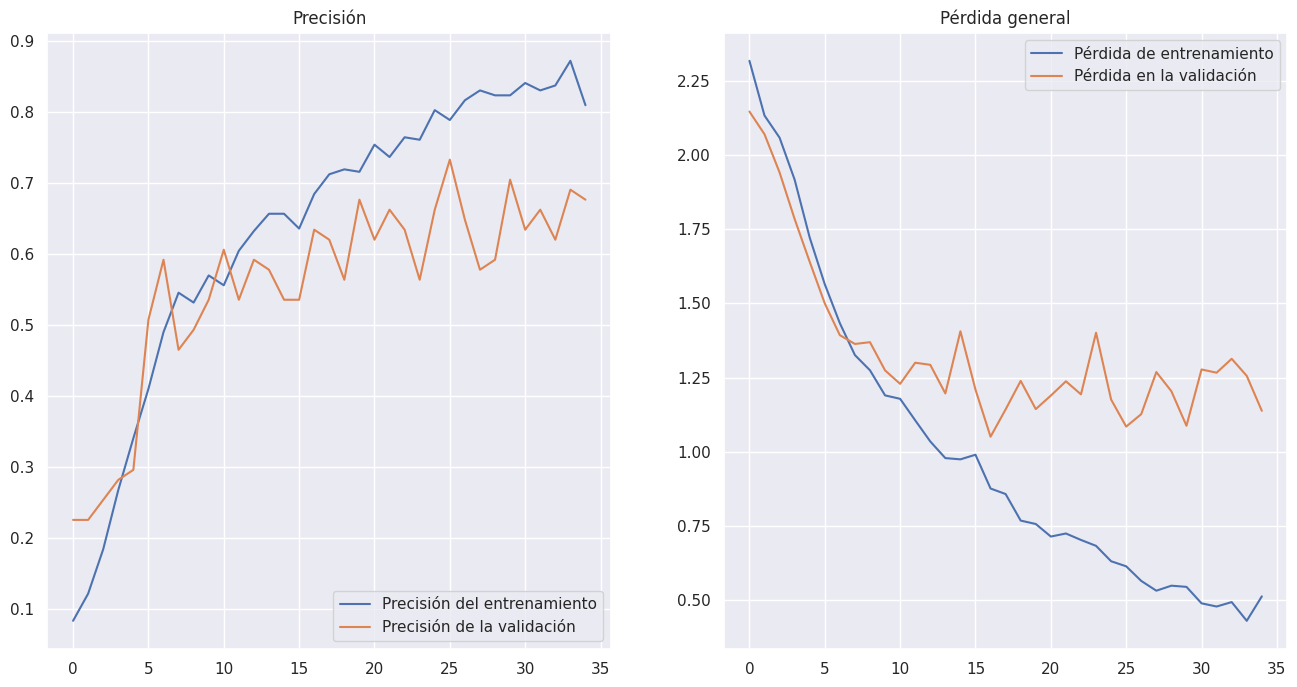

In [12]:
plt.figure(figsize=(10, 5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión del entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de la validación')
plt.legend(loc='lower right')
plt.title('Precisión')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en la validación')
plt.legend(loc='upper right')
plt.title('Pérdida general')
plt.show()

Creo una función para predecir nuevas imágenes

In [13]:
from tensorflow.keras.preprocessing import image
from PIL import Image
from io import BytesIO

import PIL
import requests

def predecir(URL : str):
  response = requests.get(URL)
  imagen = BytesIO(response.content)

  test_image = image.load_img(imagen, target_size = (64, 64))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image /= 255
  result = modelo.predict(test_image)
  sample = np.argmax(result)
  print(frutas[sample])

Pruebo el modelo.

In [14]:
# Naranja (Clasificación correcta)
predecir("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/naranja-portada-1657997149.jpg") 

1/1 [==============================] - 0s 154ms/step
orange fruit


In [15]:
# Banana (Clasificación correcta)
predecir("https://img.freepik.com/free-vector/vector-ripe-yellow-banana-bunch-isolated-white-background_1284-45456.jpg?w=360")

1/1 [==============================] - 0s 25ms/step
banana fruit


In [16]:
# Uvas (Clasificación correcta)
predecir("https://eldiariony.com/wp-content/uploads/sites/2/2022/08/Uvas-shutterstock_210742753.jpg?quality=75&strip=all&w=1200")

1/1 [==============================] - 0s 18ms/step
grapes fruit


In [17]:
# Kiwi (Clasificación correcta)
predecir("https://cdn.britannica.com/45/126445-050-4C0FA9F6/Kiwi-fruit.jpg")

1/1 [==============================] - 0s 44ms/step
kiwi fruit


In [18]:
# Manzana (Clasificación incorrecta)
predecir("https://www.recetasnestle.com.mx/sites/default/files/inline-images/tipos-de-manzana-royal-gala.jpg")

1/1 [==============================] - 0s 21ms/step
apple fruit


Guardo el modelo entrenado para usarlo en otro momento.

In [19]:
modelo.save('modelo_frutas.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!rm -rf salida

In [ ]:
!mkdir salida

In [ ]:
!tensorflowjs_converter --input_format keras modelo_frutas.h5 salida

2023-05-24 05:03:27.809871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r salida.zip salida

  adding: salida/ (stored 0%)
  adding: salida/model.json (deflated 78%)
  adding: salida/group1-shard2of2.bin (deflated 7%)
  adding: salida/group1-shard1of2.bin (deflated 8%)
